<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/PDTx_pipeline/PDTx_03_FineTuning_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#fixes a compatibility issue with the PrecollatorForGeneAndCellClassification class

!pip install --upgrade transformers==4.41
!pip install peft==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 100.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.3
    Uninstalling transformers-4.50.3:
      Successfully uninstalled transformers-4.50.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [1]:
# first mount the drive

from google.colab import drive
import os

# Mount Google Drive to access files
drive.mount('/content/drive')

# Change the working directory to the project folder in Google Drive
os.chdir("/content/drive/MyDrive/HODD/")

# Install Git Large File Storage (LFS) for handling large files in Git repositories
# !git lfs install

#Clone the Geneformer repository (commented out to avoid repeated cloning)
# !git clone https://huggingface.co/ctheodoris/Geneformer

# Navigate to the Geneformer directory
%cd Geneformer

# Install Geneformer package locally
# I found that installing Genformer first helped with a lot of the version conflict issues
!pip install .

# Install required libraries without outputting installation logs
!pip install anndata scanpy tdigest datasets

# Import necessary modules and libraries
import numpy
import transformers
import sklearn
import pickle
import sklearn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/HODD/Geneformer
Processing /content/drive/MyDrive/HODD/Geneformer
  Preparing metadata (setup.py) ... done
  Created wheel for geneformer: filename=geneformer-0.1.0-py3-none-any.whl size=2107997 sha256=ed3811dda6b95ca41d9518da946ebbe74af6e2e2cfae3c9db49b6013b48fc946
  Stored in directory: /tmp/pip-ephem-wheel-cache-v_8bwah7/wheels/cb/4a/82/85f3ca798e83d69ac023bfad48225e88e8fb2b2d2a968a51b0
Successfully built geneformer
  Attempting uninstall: geneformer
    Found existing installation: geneformer 0.1.0
    Uninstalling geneformer-0.1.0:
      Successfully uninstalled geneformer-0.1.0


In [2]:
output_prefix = "park_classifier"

data_directory = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/'

output_dir = f"/content/drive/MyDrive/HODD/models/geneformer_finetuned_v1"
!mkdir $output_dir

park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'

geneformer_directory = '/content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096'


mkdir: cannot create directory ‘/content/drive/MyDrive/HODD/models/geneformer_finetuned_v1’: File exists


##Fine-tune the model for cell state classification

In [64]:
from geneformer import Classifier

training_args = {
    "num_train_epochs": 1.5,                    # Train the model for 1.5 full passes through the data
    "learning_rate": 5e-5,                      # Controls how fast the model learns; smaller = slower, safer
    "lr_scheduler_type": "polynomial",          # Gradually reduces the learning rate using a polynomial curve
    "warmup_steps": 500,                        # Start with a smaller learning rate for the first 500 steps to stabilize training
    "weight_decay": 0.02,                       # Helps prevent overfitting by slightly shrinking the model weights
    "per_device_train_batch_size": 8,           # Number of samples the model sees at once (increase if your GPU has enough memory)
    "seed": 73,                                 # Set a random seed to make results reproducible
    "bf16": True,                               # Use bf16 (brain float 16) precision if your hardware supports it — faster & efficient
    "evaluation_strategy": "epoch",             # Run evaluation once at the end of each training epoch
    "save_strategy": "epoch",                   # Save the model after each epoch in case you want to go back to a previous version
    "load_best_model_at_end": True,             # After training, automatically load the model that performed best on validation
    "metric_for_best_model": "eval_loss",       # Use validation loss to decide which model is best
    "greater_is_better": False                  # Lower loss means better performance, so "greater is better" is set to False
}

# uses the current default model
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease_state", "states": "all"},
                training_args=training_args,
                max_ncells=None,
                freeze_layers = 2,
                num_crossval_splits = 1,
                forward_batch_size=32,
                nproc=16)

In [66]:
#datsets imports for handling tokenized dataset
from datasets import load_dataset, load_from_disk, ClassLabel

#load the training data
park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
park_data = load_from_disk(park_data_path)

# Add an 'id' column that stores the original index
park_data = park_data.add_column("id", list(range(len(park_data))))

# Get the unique values from the "disease_state_numeric" column
classes = list(set(park_data["disease_state"]))

# make the disease state column a classlabel
park_data = park_data.cast_column("disease_state", ClassLabel(names=classes))  #convert the disease state numeric column to a class label

# save it back to disk and rename disease state as label column
park_data_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_with_id_tokenized.dataset/'
park_data = park_data.rename_column("disease_state", "label")  # for compatibility with classifier_utils call in classifer.train_classifier
park_data.save_to_disk(park_data_with_id_path)

# get the test and eval splits
split_data = park_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="label") #establish train and eval with stratification

# split test and eval
train_data = split_data['train']
eval_data = split_data['test']

# # split train into training and evaluation set
# train_data, eval_data = split_data['train'].train_test_split(test_size=0.2, seed=42, stratify_by_column="label").values()

print(len(train_data))
print(len(eval_data))

# Get ids for dictionary construction
train_ids = train_data["id"]
eval_ids = eval_data["id"]

# generate dictionary for validate method
train_valid_id_split_dict = {"attr_key": "id",
                            "train": train_ids,
                            "eval": eval_ids}

Saving the dataset (0/1 shards):   0%|          | 0/5566 [00:00<?, ? examples/s]

4452
1114


In [68]:
import torch
torch.cuda.empty_cache()

os.environ["WANDB_DISABLED"] = "true"

# fine tune the model
all_metrics = cc.validate(model_directory=geneformer_directory,
                          prepared_input_data_file = park_data_with_id_path,
                          id_class_dict_file= '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl',
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          split_id_dict=train_valid_id_split_dict)
                          # to optimize hyperparameters, set n_hyperopt_trials=100 (or alternative desired # of trials)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/content/drive/MyDrive/HODD/Geneformer/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.064300,0.048239,0.988330,0.986429


/content/drive/MyDrive/HODD/Geneformer/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


  0%|          | 0/35 [00:00<?, ?it/s]

In [69]:
all_metrics

{'conf_matrix':                    normal  Parkinson_disease
 normal              342.0                5.0
 Parkinson_disease     8.0              759.0,
 'macro_f1': [np.float64(0.986428727390974)],
 'acc': [0.9883303411131059],
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.98305085, 0.9934811 , 0.99478488, 0.99478488,
         0.99608866, 0.99608866, 0.99608866, 0.99608866, 0.99608866,
         0.99739244, 0.99739244, 0.99739244, 0.99739244, 0.99739244,
         0.99739244, 0.99869622, 0.99869622, 0.99869622, 0.99869622,
         0.99869622, 0.99869622, 0.99869622, 0.99869622, 0.99869622,
         0.99869622, 0.99962247, 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.  

##Evaluate the model

In [70]:
#add ids to the test data

#load the test data
park_data_test_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_test_tokenized.dataset/'
park_data_test = load_from_disk(park_data_test_path)

# Add an 'id' column that stores the original index
park_data_test = park_data_test.add_column("id", list(range(len(park_data_test))))

# Get the unique values from the "disease_state_numeric" column
classes = list(set(park_data_test["disease_state"]))

# make the disease state column a classlabel
park_data_test = park_data_test.cast_column("disease_state", ClassLabel(names=classes))  #convert the disease state numeric column to a class label

#rename the disease_state column as label

park_data_test = park_data_test.rename_column("disease_state", "label")

# save it back to disk

park_data_test_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_test_labeled_tokenized.dataset/'

park_data_test.save_to_disk(park_data_test_with_id_path)

Saving the dataset (0/1 shards):   0%|          | 0/900 [00:00<?, ? examples/s]

In [71]:
#saved previous model locations due to gpu memory issues

current_model = '/content/drive/MyDrive/HODD/models/geneformer_finetuned_v1/250414_geneformer_cellClassifier_park_classifier/ksplit1/'
current_dict = '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl'
test_data_file = park_data_test_with_id_path
output_dir = '/content/drive/MyDrive/HODD/models/geneformer_finetuned_v1/'
output_prefix = "park_classifier"

In [72]:
from geneformer import Classifier

cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease_state", "states": "all"},
                forward_batch_size=36,
                nproc=16)

In [73]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory=current_model,
        id_class_dict_file=current_dict,
        test_data_file = test_data_file,
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/25 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

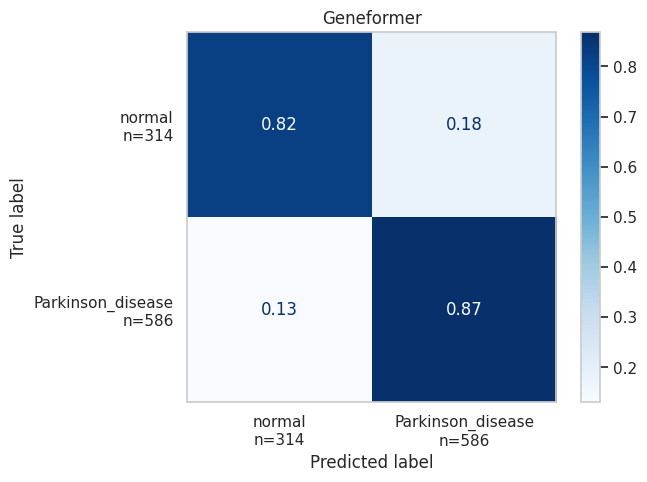

In [74]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
        # custom_class_order=["nf","hcm","dcm"],
)

<Figure size 1500x1500 with 0 Axes>

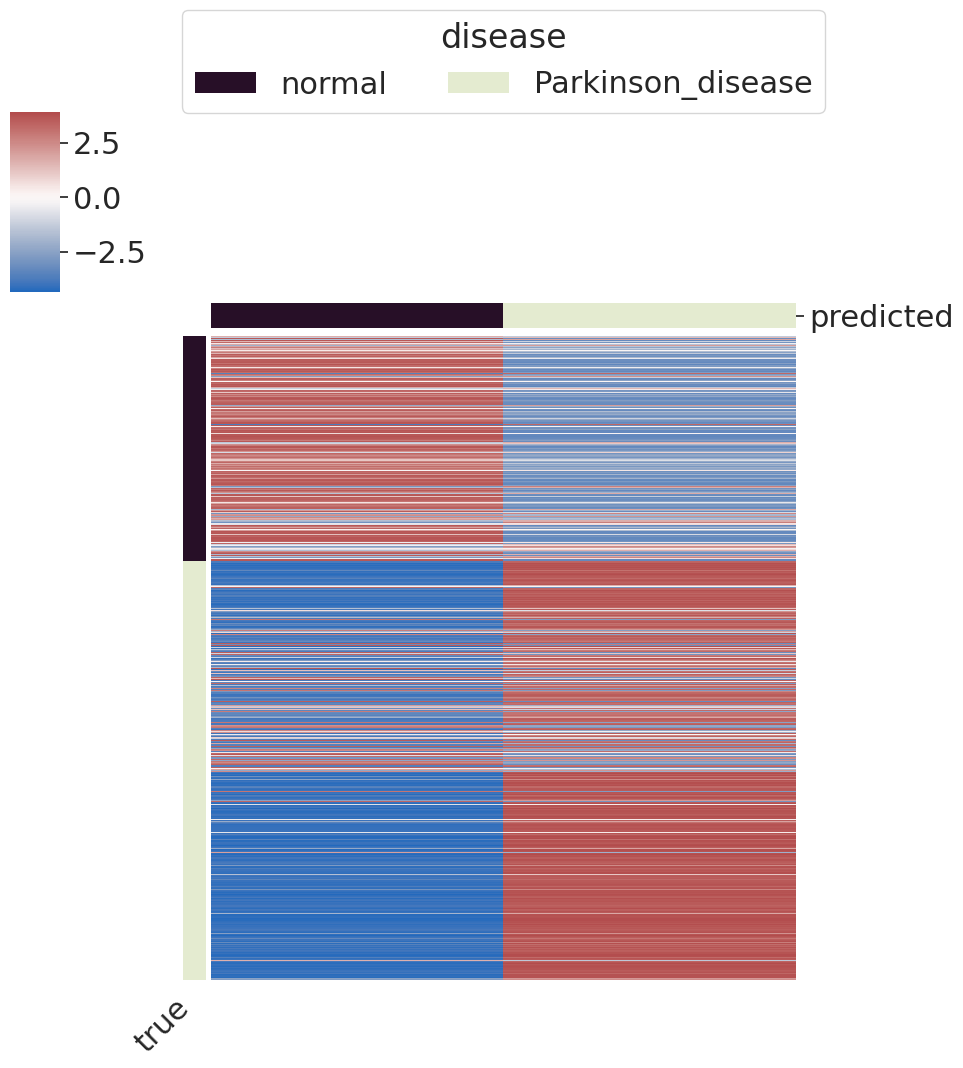

In [75]:
cc.plot_predictions(
    predictions_file=f"{output_dir}{output_prefix}_pred_dict.pkl",
    id_class_dict_file = current_dict,
    title="disease",
    output_directory=output_dir,
    output_prefix=output_prefix,
)